In [149]:
import tensorflow as tf

In [150]:
from keras.preprocessing.image import ImageDataGenerator

In [151]:
import os, shutil

In [152]:
print(os.getcwd())

/Users/alessandrobiagi/Desktop/Kaggle_Datasets/Kaggle_Bradipi/FoodRecognition/scripts


In [153]:
def creating_dataset_directories(type_dir, category):
    new_cat_dir = os.path.join(type_dir, category)
    if not new_cat_dir:
        os.mkdir(new_cat_dir)


In [154]:
# Directory where you'll store your dataset
base_dir = '../src/food-101/'

# Directories for the training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
if not train_dir:
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not validation_dir:
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not test_dir:
    os.mkdir(test_dir)

In [155]:
categories = ['sashimi', 'spaghetti_bol']
type_dirs = [train_dir, validation_dir, test_dir]

for category in categories:
    for type_dir in type_dirs:
        creating_dataset_directories(type_dir=type_dir,
                                     category=category)

In [156]:
sashimi_dir = base_dir + 'images/sashimi'
spaghetti_bol_dir = base_dir + 'images/spaghetti_bolognese'

sashimi_names = os.listdir(sashimi_dir)
sashimi_full_names = [os.path.join(sashimi_dir, x) for x in sashimi_names]

spaghetti_bol_names = os.listdir(spaghetti_bol_dir)
spaghetti_bol_full_names = [os.path.join(spaghetti_bol_dir, x) for x in spaghetti_bol_names]


In [157]:
print(len(sashimi_full_names))
print(len(spaghetti_bol_names))

1000
1000


In [158]:
sashimi_train_names = sashimi_full_names[0:700]
sashimi_val_names = sashimi_full_names[700:850]
sashimi_test_names = sashimi_full_names[850:1000]

In [159]:
spaghetti_bol_train_names = spaghetti_bol_full_names[0:700]
spaghetti_bol_val_names = spaghetti_bol_full_names[700:850]
spaghetti_bol_test_names = spaghetti_bol_full_names[850:1000]

In [160]:
def creating_datasets(dataset_names, dst_dir, type_dir, category):
    for x in dataset_names:
        img_name = x.split("/")[-1]
        dst_dir_type = os.path.join(dst_dir, type_dir)
        dst_dir_full = os.path.join(dst_dir_type, category)
        dst = os.path.join(dst_dir_full, img_name)
        shutil.copy(x, dst)

In [161]:
base_dst_dir_dataset = '../src/food-101'
sashimi_names_list = [sashimi_train_names, sashimi_val_names, sashimi_test_names]
spaghetti_bol_list = [spaghetti_bol_train_names, spaghetti_bol_val_names, spaghetti_bol_test_names]
type_dataset = ['train', 'validation', 'test']
categories_dataset = ['sashimi', 'spaghetti_bol']

In [162]:
for category in categories_dataset:
    if category == 'sashimi':
        dataset_names_list = sashimi_names_list
    elif category == 'spaghetti_bol':
        dataset_names_list = spaghetti_bol_list

In [163]:
creating_datasets(dataset_names=sashimi_train_names,
                 dst_dir='../src/food-101/',
                 type_dir='train',
                 category='sashimi')

In [164]:
creating_datasets(dataset_names=sashimi_val_names,
                 dst_dir='../src/food-101/',
                 type_dir='validation',
                 category='sashimi')

In [165]:
creating_datasets(dataset_names=sashimi_test_names,
                 dst_dir='../src/food-101/',
                 type_dir='test',
                 category='sashimi')

In [166]:
creating_datasets(dataset_names=spaghetti_bol_train_names,
                 dst_dir='../src/food-101/',
                 type_dir='train',
                 category='spaghetti_bol')

In [167]:
creating_datasets(dataset_names=spaghetti_bol_val_names,
                 dst_dir='../src/food-101/',
                 type_dir='validation',
                 category='spaghetti_bol')

In [168]:
creating_datasets(dataset_names=spaghetti_bol_test_names,
                 dst_dir='../src/food-101/',
                 type_dir='test',
                 category='spaghetti_bol')

In [169]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [55]:
train_dir

'../src/food-101/train'

In [23]:
train_generator = train_datagen.flow_from_directory(
                                train_dir,
                                target_size=(150, 150), # resize all images to 150 x 150
                                batch_size=20,
                                class_mode='binary')

Found 1400 images belonging to 2 classes.


In [24]:
validation_generator = test_datagen.flow_from_directory(
                                validation_dir,
                                target_size=(150, 150),
                                batch_size=20,
                                class_mode='binary')

Found 300 images belonging to 2 classes.


In [25]:
from keras import layers
from keras import models

# Features extractor
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [26]:
# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [28]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [63]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=70,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=15)

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
70/70 [==============================] - 31s 433ms/step - loss: 0.6319 - acc: 0.6344 - val_loss: 0.4521 - val_acc: 0.7900
Epoch 2/30
70/70 [==============================] - 31s 438ms/step - loss: 0.4275 - acc: 0.8052 - val_loss: 0.3705 - val_acc: 0.8533
Epoch 3/30
70/70 [==============================] - 31s 438ms/step - loss: 0.3141 - acc: 0.8736 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 4/30
70/70 [==============================] - 31s 438ms/step - loss: 0.2681 - acc: 0.8880 - val_loss: 0.2800 - val_acc: 0.8900
Epoch 5/30
70/70 [==============================] - 31s 435ms/step - loss: 0.2327 - acc: 0.9037 - val_loss: 0.2197 - val_acc: 0.9133
Epoch 6/30
70/70 [==============================] - 32s 464ms/step - loss: 0.2230 - acc: 0.9058 - val_loss: 0.2551 - val_acc: 0.8967
Epoch 7/30
70/70 [==============================] - 33s 469ms/step - loss: 0.2326 - acc: 0.9178 - val_loss: 0.2145 - val_acc: 0.9167
Epoch 8/30
70/70 [==============================] - 32s 451ms/step - 

In [64]:
model.save('../models/conv_net_20201228_1.h5')

In [67]:
history.history

{'loss': [0.5732683539390564,
  0.401833176612854,
  0.31424033641815186,
  0.2526271641254425,
  0.21427729725837708,
  0.21375614404678345,
  0.2059619426727295,
  0.1875188946723938,
  0.16028593480587006,
  0.1614397168159485,
  0.14478081464767456,
  0.13128234446048737,
  0.13172204792499542,
  0.12265979498624802,
  0.10888516902923584,
  0.1039871871471405,
  0.09312955290079117,
  0.08908472955226898,
  0.07202228903770447,
  0.07798997312784195,
  0.0498427152633667,
  0.04982469975948334,
  0.05827052891254425,
  0.04058379679918289,
  0.03943557292222977,
  0.046411819756031036,
  0.03021511621773243,
  0.02880350686609745,
  0.04199346527457237,
  0.01756606437265873],
 'acc': [0.6985714435577393,
  0.8199999928474426,
  0.8692857027053833,
  0.8999999761581421,
  0.9157142639160156,
  0.9221428632736206,
  0.925000011920929,
  0.9257143139839172,
  0.9399999976158142,
  0.9364285469055176,
  0.941428542137146,
  0.949999988079071,
  0.9571428298950195,
  0.954999983310699

In [46]:
import matplotlib.pyplot as plt

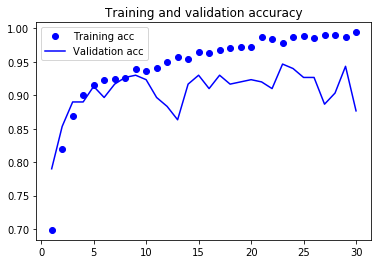

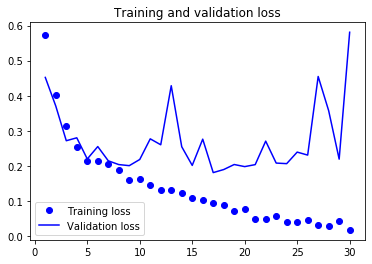

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [50]:
from keras.preprocessing import image

sashimi_sample = sashimi_train_names[0]
spaghetti_bol_sample = spaghetti_bol_train_names[0]
img_sashimi = image.load_img(sashimi_sample, target_size=(150, 150))
print(type(img_sashimi))

<class 'PIL.Image.Image'>


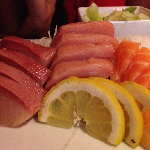

In [51]:
img_sashimi



In [42]:
x_sashimi = image.img_to_array(img_sashimi)
x_sashimi = x_sashimi.reshape((1,) + x_sashimi.shape)

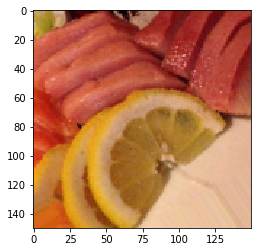

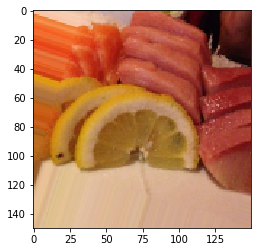

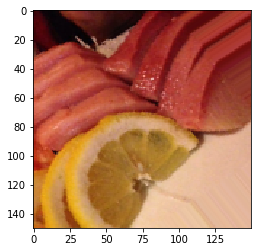

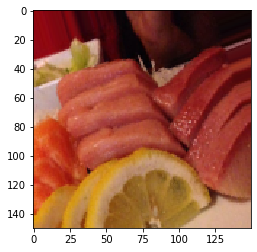

In [55]:
i = 0
for batch in datagen.flow(x_sashimi, batch_size=1):
    plt.figure()
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i = i + 1
    if i % 4 == 0:
        break
plt.show()

In [68]:
# Features extractor
model_drop = models.Sequential()
model_drop.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3)))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_drop.add(layers.MaxPooling2D((2, 2)))

In [69]:
# Classifier with dropout
model_drop.add(layers.Flatten())
model_drop.add(layers.Dropout(0.2))
model_drop.add(layers.Dense(512, activation='relu'))
model_drop.add(layers.Dense(1, activation='sigmoid'))

In [76]:
from keras import optimizers
model_drop.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [59]:
# training model_drop using data augmentation
train_datagen_drop = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen_drop = ImageDataGenerator(rescale=1./255)

train_generator_drop = train_datagen_drop.flow_from_directory(
                                            train_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

validation_generator_drop = test_datagen_drop.flow_from_directory(
                                            validation_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

In [81]:
history_drop = model_drop.fit_generator(
                            train_generator_drop,
                            steps_per_epoch=70,
                            epochs=40,
                            validation_data=validation_generator_drop,
                            validation_steps=15)

Epoch 1/40
70/70 [==============================] - 33s 459ms/step - loss: 0.4201 - acc: 0.8094 - val_loss: 0.3859 - val_acc: 0.8133
Epoch 2/40
70/70 [==============================] - 33s 462ms/step - loss: 0.3828 - acc: 0.8411 - val_loss: 0.3632 - val_acc: 0.8267
Epoch 3/40
70/70 [==============================] - 32s 461ms/step - loss: 0.3691 - acc: 0.8411 - val_loss: 0.2393 - val_acc: 0.8900
Epoch 4/40
70/70 [==============================] - 32s 461ms/step - loss: 0.3034 - acc: 0.8755 - val_loss: 0.4105 - val_acc: 0.8200
Epoch 5/40
70/70 [==============================] - 32s 456ms/step - loss: 0.2880 - acc: 0.8606 - val_loss: 0.4563 - val_acc: 0.8033
Epoch 6/40
70/70 [==============================] - 32s 455ms/step - loss: 0.2921 - acc: 0.8898 - val_loss: 0.2186 - val_acc: 0.9067
Epoch 7/40
70/70 [==============================] - 32s 456ms/step - loss: 0.2487 - acc: 0.9081 - val_loss: 0.2325 - val_acc: 0.9067
Epoch 8/40
70/70 [==============================] - 32s 456ms/step - 

In [98]:
def nn_performance(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

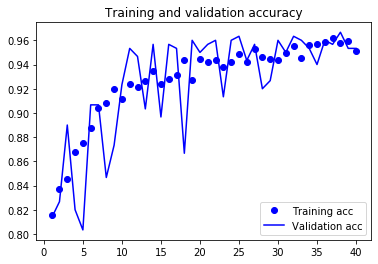

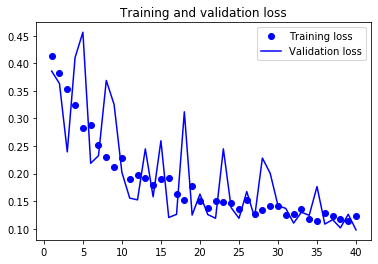

In [89]:
nn_performanceperformance(history_drop)

In [93]:
model_drop.save('../models/conv_net_20201229_1.h5')

In [23]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [87]:
import keras
print(keras.__version__)

2.4.3


In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [95]:
# feature extraction without data augmentation
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [98]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                        directory,
                        target_size=(150, 150),
                        batch_size=batch_size,
                        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1400)

Found 1400 images belonging to 2 classes.


In [99]:
validation_features, validation_labels = extract_features(validation_dir, 300)

Found 300 images belonging to 2 classes.


In [121]:
test_features, test_labels = extract_features(test_dir, 300)

Found 300 images belonging to 2 classes.


In [122]:
train_features = np.reshape(train_features, (1400, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (300, 4 * 4 * 512))
test_features = np.reshape(test_features, (300, 4 * 4 * 512))

In [123]:
model_conv = models.Sequential()
model_conv.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_conv.add(layers.Dropout(0.2))
model_conv.add(layers.Dense(1, activation='sigmoid'))

In [126]:
model_conv.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [127]:
history_conv = model_conv.fit(train_features, train_labels,
                             epochs=40,
                             batch_size=20,
                             validation_data=(validation_features, validation_labels))

Epoch 1/40
70/70 [==============================] - 1s 13ms/step - loss: 0.5142 - acc: 0.7580 - val_loss: 0.2400 - val_acc: 0.9567
Epoch 2/40
70/70 [==============================] - 1s 16ms/step - loss: 0.2167 - acc: 0.9415 - val_loss: 0.1648 - val_acc: 0.9633
Epoch 3/40
70/70 [==============================] - 1s 12ms/step - loss: 0.1425 - acc: 0.9649 - val_loss: 0.1403 - val_acc: 0.9700
Epoch 4/40
70/70 [==============================] - 1s 14ms/step - loss: 0.1250 - acc: 0.9534 - val_loss: 0.1281 - val_acc: 0.9733
Epoch 5/40
70/70 [==============================] - 1s 15ms/step - loss: 0.0998 - acc: 0.9728 - val_loss: 0.1184 - val_acc: 0.9800
Epoch 6/40
70/70 [==============================] - 1s 13ms/step - loss: 0.0821 - acc: 0.9803 - val_loss: 0.1130 - val_acc: 0.9800
Epoch 7/40
70/70 [==============================] - 1s 12ms/step - loss: 0.0810 - acc: 0.9756 - val_loss: 0.1093 - val_acc: 0.9800
Epoch 8/40
70/70 [==============================] - 1s 12ms/step - loss: 0.0624 - a

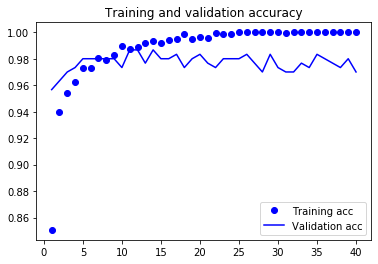

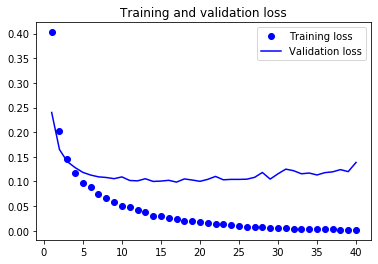

In [128]:
nn_performance(history_conv)

In [129]:
model_conv.save('../models/conv_net_20201229_2.h5')

In [85]:
from keras import models, layers
# Using pre-trained net with data augmentation
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

model_conv_aug = models.Sequential()
model_conv_aug.add(conv_base)
model_conv_aug.add(layers.Flatten())
model_conv_aug.add(layers.Dense(256, activation='relu'))
model_conv_aug.add(layers.Dense(1, activation='sigmoid'))

print(len(model_conv_aug.trainable_weights))
conv_base.trainable = False
print(len(model_conv_aug.trainable_weights))


30
4


In [86]:
# training model_drop using data augmentation
train_datagen_conv_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen_conv_aug = ImageDataGenerator(rescale=1./255)

train_generator_conv_aug = train_datagen_conv_aug.flow_from_directory(
                                            train_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

validation_generator_conv_aug = test_datagen_conv_aug.flow_from_directory(
                                            validation_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [87]:
model_conv_aug.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [88]:
history_conv_aug = model_conv_aug.fit_generator(
                            train_generator_conv_aug,
                            steps_per_epoch=70,
                            epochs=3,
                            validation_data=validation_generator_conv_aug,
                            validation_steps=15)

Epoch 1/3
70/70 [==============================] - 148s 2s/step - loss: 0.5798 - acc: 0.7135 - val_loss: 0.2628 - val_acc: 0.9600
Epoch 2/3
70/70 [==============================] - 147s 2s/step - loss: 0.2631 - acc: 0.9373 - val_loss: 0.1695 - val_acc: 0.9700
Epoch 3/3
70/70 [==============================] - 147s 2s/step - loss: 0.2008 - acc: 0.9411 - val_loss: 0.1436 - val_acc: 0.9667


In [89]:
model_conv_aug.save('../models/conv_net_20201230_1.h5')

In [90]:
model_conv_aug.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
print(len(conv_base.trainable_weights))

6


In [91]:
# Fine Tuning
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [92]:
conv_base.layers

In [56]:
# new_model = keras.models.load_model('path_to_my_model.h5')

In [93]:
from tensorflow import keras
model_tuning = keras.models.load_model('../models/conv_net_20201230_1.h5')

In [94]:
model_tuning.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [95]:
from keras import optimizers
model_tuning.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=1e-5),
                    metrics=['acc'])

In [97]:
history_tuning = model_tuning.fit_generator(train_generator_conv_aug,
                                           steps_per_epoch=70,
                                           epochs=3,
                                           validation_data=validation_generator_conv_aug,
                                           validation_steps=15)

Epoch 1/3
70/70 [==============================] - 160s 2s/step - loss: 0.1689 - acc: 0.9457 - val_loss: 0.1311 - val_acc: 0.9700
Epoch 2/3
70/70 [==============================] - 147s 2s/step - loss: 0.1668 - acc: 0.9443 - val_loss: 0.1254 - val_acc: 0.9700
Epoch 3/3
70/70 [==============================] - 147s 2s/step - loss: 0.1519 - acc: 0.9493 - val_loss: 0.1212 - val_acc: 0.9700


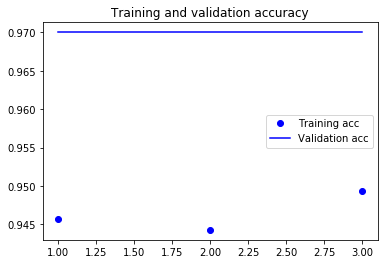

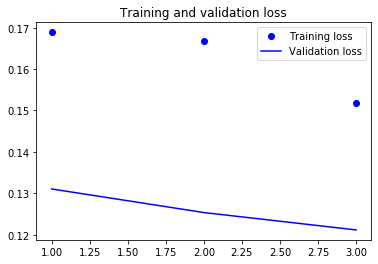

In [102]:
import matplotlib.pyplot as plt
nn_performance(history_tuning)

In [101]:
model_tuning.save('../models/conv_net_20201230_2.h5')

In [172]:
# smoothing the plots
import matplotlib.pyplot as plt

def nn_performance_smoothed(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs,
        smooth_curve(acc), 'bo', label='Smoothed training acc')
    plt.plot(epochs,
        smooth_curve(val_acc), 'b', label='Smoothed validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
    plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



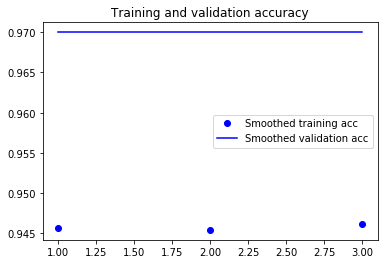

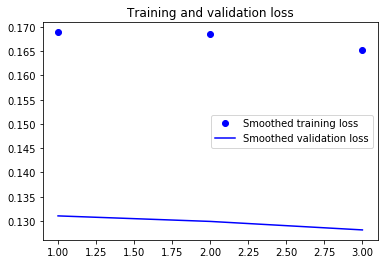

In [173]:
nn_performance_smoothed(history_tuning)

In [171]:
test_generator = test_datagen_conv_aug.flow_from_directory(
                                test_dir,
                                target_size=(150, 150),
                                batch_size=20,
                                class_mode='binary')

test_loss, test_acc = model_tuning.evaluate_generator(test_generator, steps=15)
print('test_acc', test_acc)

Found 300 images belonging to 2 classes.
test_acc 0.9466666579246521


In [1]:
# visualizing intermediate activations
from tensorflow import keras
model_vis = keras.models.load_model('../models/conv_net_20201229_1.h5')

In [2]:
model_vis.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [26]:
img_path = '../src/food-101/test/sashimi/1039599.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)

img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. # the model was trained on inputs that were preprocessed this way
print(img_tensor.shape)

(150, 150, 3)
(1, 150, 150, 3)


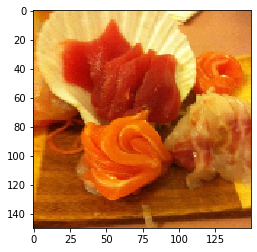

In [27]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [32]:
from keras import models

layer_outputs = [layer.output for layer in model_vis.layers[:8]]
activation_model = models.Model(inputs=model_vis.input, outputs=layer_outputs)

In [42]:
activations = activation_model.predict(img_tensor)
print(len(activations))

8


In [46]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


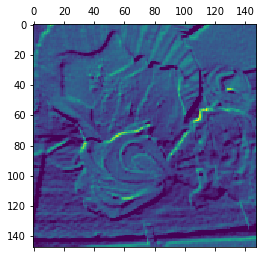

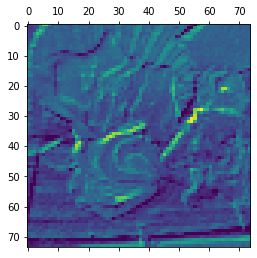

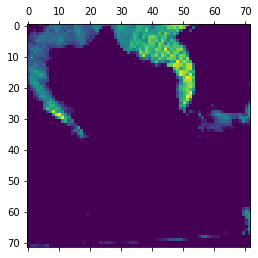

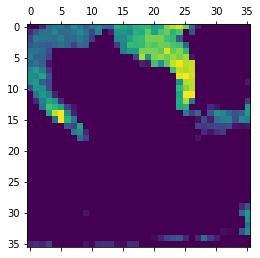

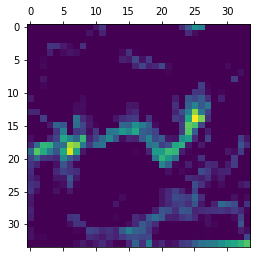

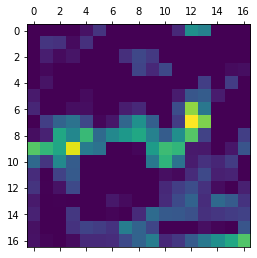

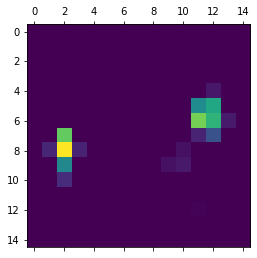

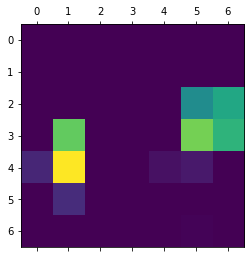

In [55]:
for i in activations:
    plt.matshow(i[0, :, :, 8], cmap='viridis')

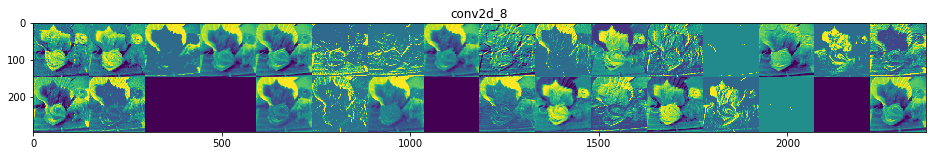

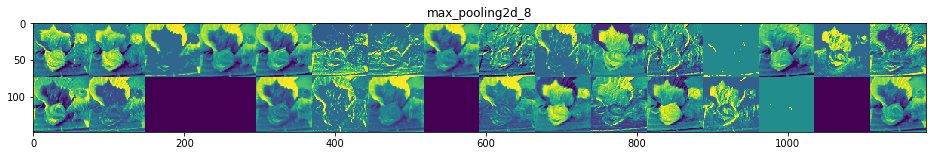

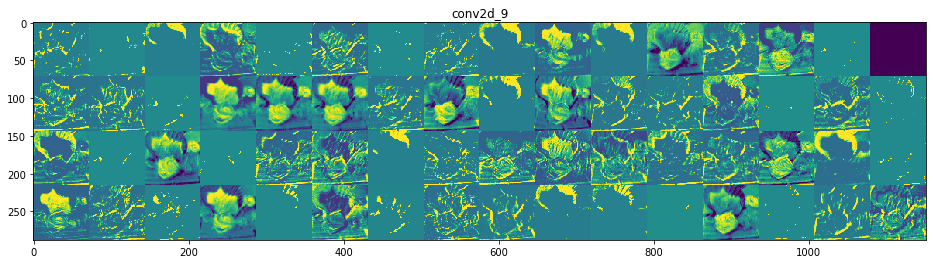

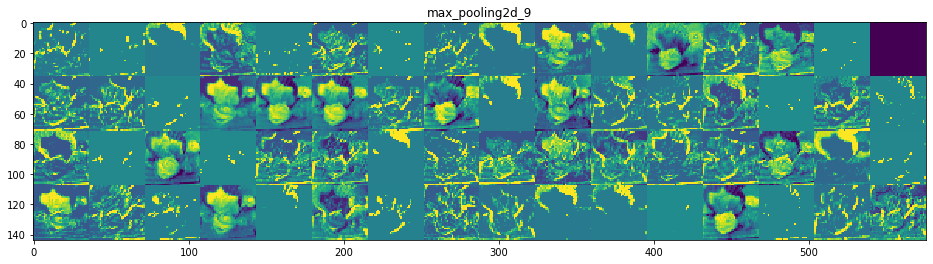

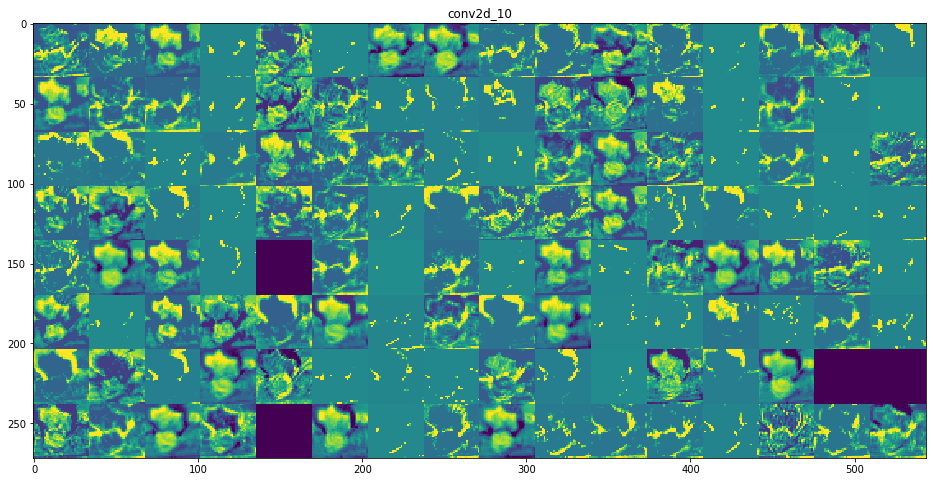

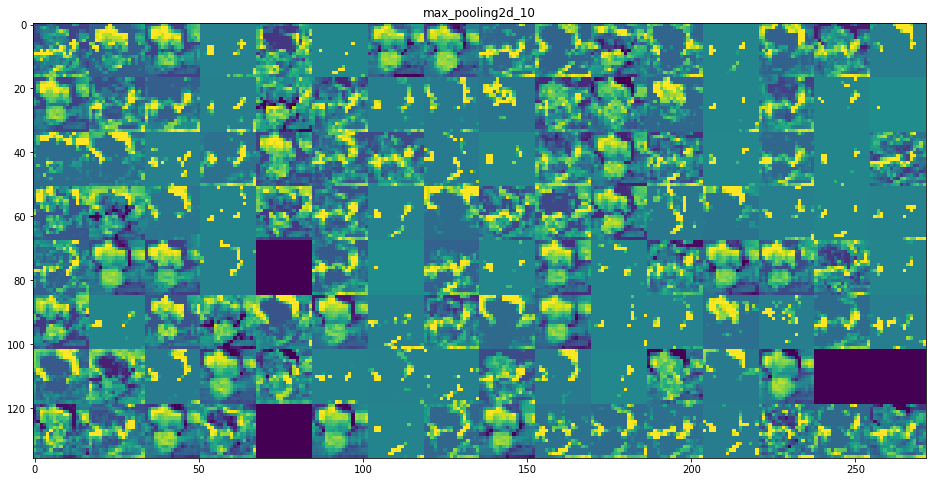

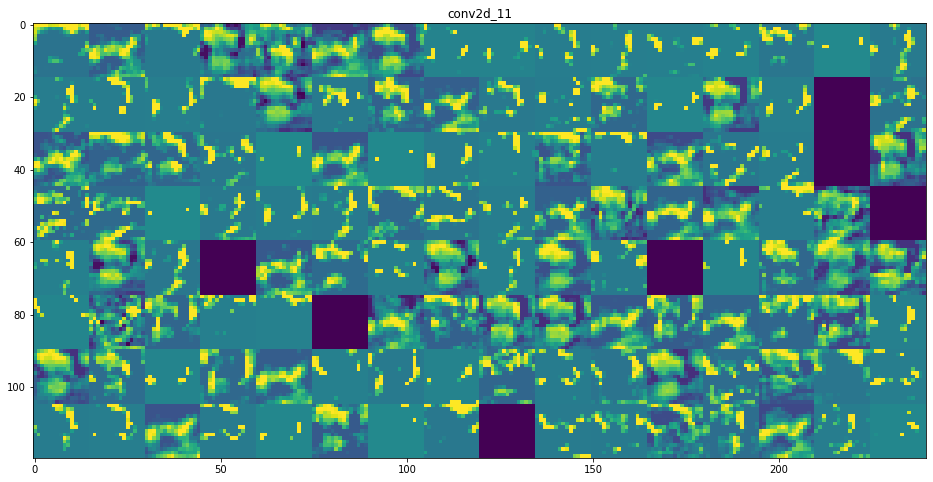

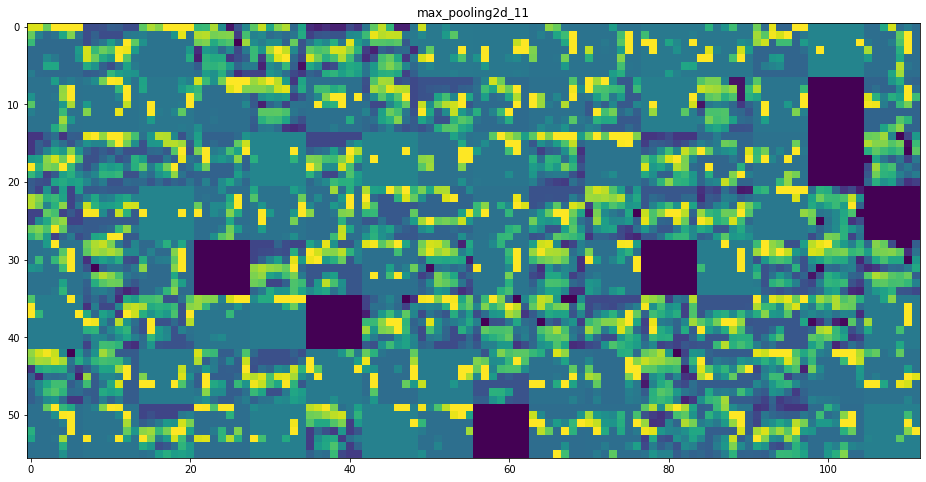

In [61]:
# visualizing every channel in every intermediate activation
layer_names = []
for layer in model_vis.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1] # the feature map has shape (l, size, size, n_features)
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
        
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
        
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [10]:
# visualizing convnet filters
# defining the loss tensor for filter visualization
import tensorflow as tf
from keras.applications import VGG16
from keras import backend as K

model_filters = VGG16(weights='imagenet',
                     include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model_filters.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [16]:
# obtaining the gradient of the loss with regard to the input
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, model_filters.input)[0]

In [17]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [22]:
# Fetching Numpy output values given Numpy input values
iterate = K.function([model_filters.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [24]:
# loss maximation via stochastic gradient descent
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [25]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [98]:
# Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model_filters.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model_filters.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model_filters.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    # print(deprocess_image(img).shape)
    return deprocess_image(img)

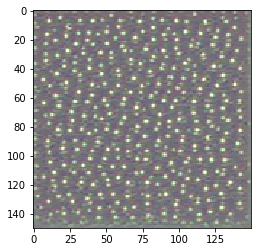

In [99]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

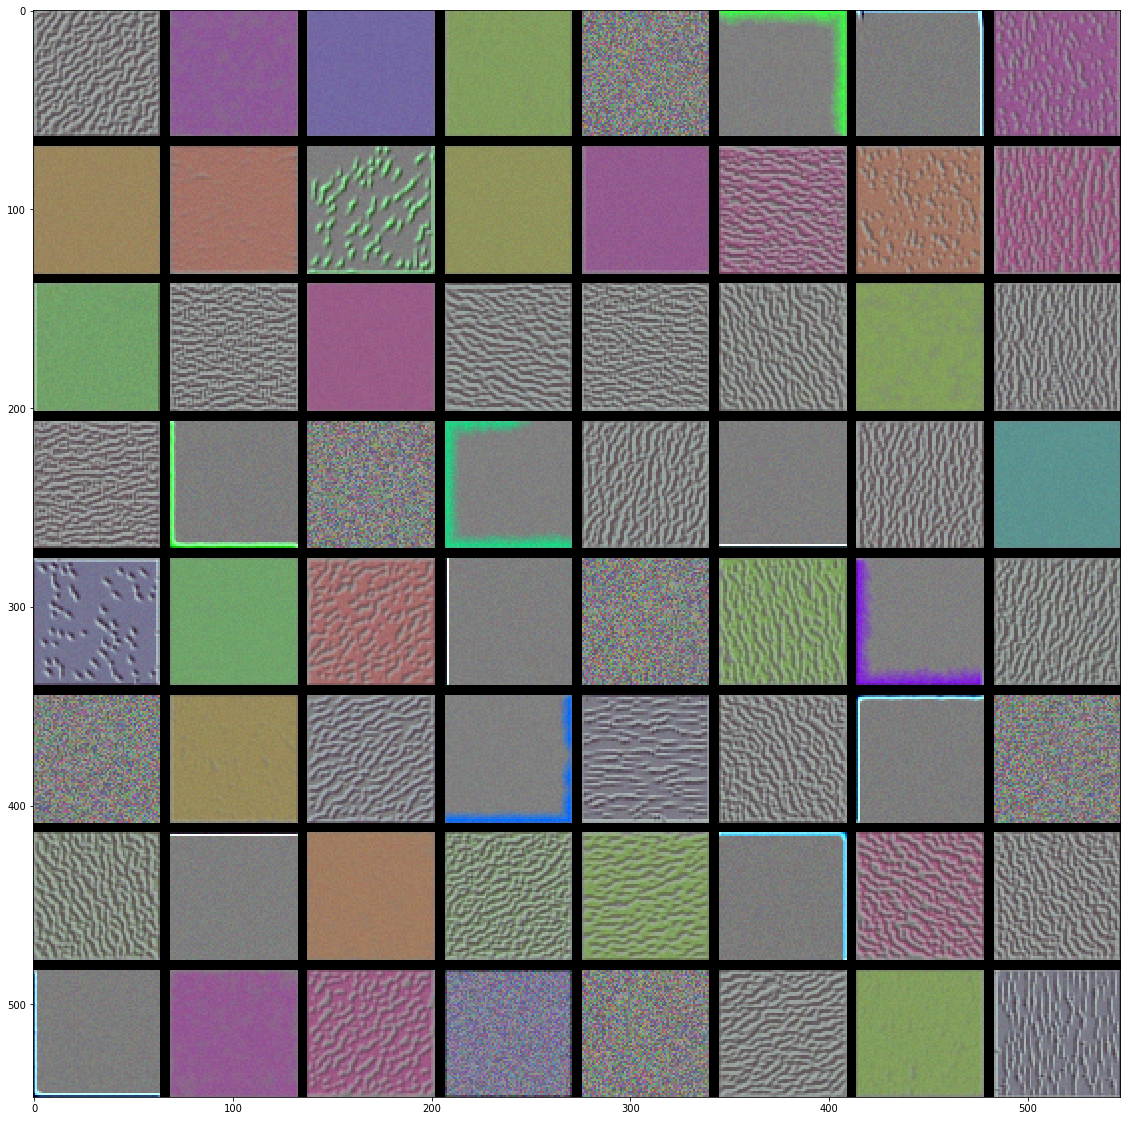

In [100]:
# generating a grid of all filter response patterns in a layer
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
results = results.astype(int)
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [97]:
# Visualizing heatmaps of class activation
# cam visualization
from keras.applications.vgg16 import VGG16
model_cam = VGG16(weights='imagenet')

In [52]:
from keras.applications.vgg16 import preprocess_input

In [82]:
# preprocessing an input image for VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '../src/food-101/test/spaghetti_bol/1915989.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [83]:
preds = model_cam.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n07831146', 'carbonara', 0.50861275), ('n07579787', 'plate', 0.26391315), ('n04263257', 'soup_bowl', 0.10967648)]


In [84]:
np.argmax(preds[0])

959

In [85]:
spaghetti_output = model_cam.output[:, 959]
last_conv_layer = model_cam.get_layer('block5_conv3')

grads = K.gradients(spaghetti_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model_cam.input],
                    [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

<Figure size 3600x3600 with 0 Axes>

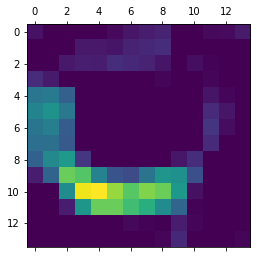

In [86]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure(figsize=(50, 50))
plt.matshow(heatmap)

In [87]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [88]:
import cv2

In [89]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('../src/food-101/test/superimposed.jpg', superimposed_img)

True

In [77]:
img_path

'../src/food-101/test/spaghetti_bol/1915989.jpg'